# SetUp

In [ ]:
# Mounting the drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Checking for the GPU
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Loading the data

In [ ]:
# Loading the libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
# Loading the dataset
meta_df = pd.read_csv('metadata.csv',
                      dtype={'pubmed_id': str,'mag_id': str, 's2_id': str})
meta_df.head()

C:\Users\sushb\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5,13,14,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [ ]:
all_json = glob.glob('C:/Users/sushb/Downloads/551982_1490480_bundle_archive/document_parses/pdf_json/**/*.json', recursive=True)
len(all_json)

104152

In [ ]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

0000028b5cc154f68b8a269f6578f21e31f62977: ... According to current live statistics at the time of editing this letter, Russia has been the third country in the world to be affected by COVID-19 with both new cases and death rates rising. It remain...


In [ ]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [ ]:
# Loading the data into DataFrame
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 104152
Processing index: 10415 of 104152
Processing index: 20830 of 104152
Processing index: 31245 of 104152
Processing index: 41660 of 104152
Processing index: 52075 of 104152
Processing index: 62490 of 104152
Processing index: 72905 of 104152
Processing index: 83320 of 104152
Processing index: 93735 of 104152
Processing index: 104150 of 104152


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,"Cornelissen, E.. Dewerchin, H. L.. Van Hamm...",Absence of surface expression of feline<br>in...,Veterinary Microbiology,Feline infectious peritonitis virus (FIPV)<br...
1,0003793cf9e709bc2b9d0c8111186f78fb73fc04,10.1016/j.msard.2020.102139,,How do we protect our 'high-risk' patient popu...,"Vishnevetsky, Anastasia. Levy, Michael",Rethinking high-risk groups in COVID-19,Mult Scler Relat Disord,Not provided.
2,00039b94e6cb7609ecbddee1755314bcfeb77faa,10.1111/j.1365-2249.2004.02415.x,Severe acute respiratory syndrome (SARS) is a ...,Severe acute respiratory syndrome (SARS) is a ...,"WONG, C K. LAM, C W K. WU, A K L. IP, W K....",Plasma inflammatory cytokines and chemokines<...,Clinical & Experimental Immunology,Severe acute respiratory syndrome (SARS) is a...
3,0003ddc51c4291d742855e9ac56076a3bea33ad7,10.1016/j.bbi.2020.06.003,,It is said that crisis reveals character. The ...,"Ajilore, Olusola. Thames, April D.","The Fire This Time: The Stress of Racism,<br>...",Brain Behav Immun,Not provided.
4,0004456994f6c1d5db7327990386d33c01cff32a,10.1186/1471-2334-10-8,Background: Influenza immunisation for healthc...,The German standing commission for immunisatio...,"Williams, Chris J. Schweiger, Brunhilde. <br...",Seasonal influenza risk in hospital<br>health...,BMC Infect Dis,Background: Influenza immunisation for<br>hea...


# Feature Engineering

In [ ]:

df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,"Cornelissen, E.. Dewerchin, H. L.. Van Hamm...",Absence of surface expression of feline<br>in...,Veterinary Microbiology,Feline infectious peritonitis virus (FIPV)<br...,165,2071,756
1,0003793cf9e709bc2b9d0c8111186f78fb73fc04,10.1016/j.msard.2020.102139,,How do we protect our 'high-risk' patient popu...,"Vishnevetsky, Anastasia. Levy, Michael",Rethinking high-risk groups in COVID-19,Mult Scler Relat Disord,Not provided.,0,943,486
2,00039b94e6cb7609ecbddee1755314bcfeb77faa,10.1111/j.1365-2249.2004.02415.x,Severe acute respiratory syndrome (SARS) is a ...,Severe acute respiratory syndrome (SARS) is a ...,"WONG, C K. LAM, C W K. WU, A K L. IP, W K....",Plasma inflammatory cytokines and chemokines<...,Clinical & Experimental Immunology,Severe acute respiratory syndrome (SARS) is a...,179,2822,1103
3,0003ddc51c4291d742855e9ac56076a3bea33ad7,10.1016/j.bbi.2020.06.003,,It is said that crisis reveals character. The ...,"Ajilore, Olusola. Thames, April D.","The Fire This Time: The Stress of Racism,<br>...",Brain Behav Immun,Not provided.,0,986,491
4,0004456994f6c1d5db7327990386d33c01cff32a,10.1186/1471-2334-10-8,Background: Influenza immunisation for healthc...,The German standing commission for immunisatio...,"Williams, Chris J. Schweiger, Brunhilde. <br...",Seasonal influenza risk in hospital<br>health...,BMC Infect Dis,Background: Influenza immunisation for<br>hea...,365,4414,1396


In [ ]:
# Handle Duplicates
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     64295
unique    44321
top            
freq      19761
Name: abstract, dtype: object

In [ ]:
df_covid['body_text'].describe(include='all')

count                                                 64295
unique                                                64290
top       The use of indicator organisms for estuarine a...
freq                                                      2
Name: body_text, dtype: object

In [ ]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,64295.000000,64295.000000,64295.000000
mean,152.494922,4322.245587,1301.890427
std,186.495962,9265.283219,1533.415708
min,0.000000,1.000000,1.000000
25%,0.000000,1640.000000,699.000000
50%,146.000000,3093.000000,1093.000000
75%,230.000000,4825.000000,1523.000000
max,7415.000000,279623.000000,38298.000000


In [ ]:
# Data Pre-Processing
df_covid.dropna(inplace=True)
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57497 entries, 0 to 64445
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             57497 non-null  object
 1   doi                  57497 non-null  object
 2   abstract             57497 non-null  object
 3   body_text            57497 non-null  object
 4   authors              57497 non-null  object
 5   title                57497 non-null  object
 6   journal              57497 non-null  object
 7   abstract_summary     57497 non-null  object
 8   abstract_word_count  57497 non-null  int64 
 9   body_word_count      57497 non-null  int64 
 10  body_unique_words    57497 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 5.3+ MB


In [ ]:
# Handling Multiple Languages
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df_covid))):
    # split by space into list, take the first x intex, join with space
    text = df_covid.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 57497/57497 [04:39<00:00, 205.60it/s]


In [ ]:
# All the languages that are found in the dataset
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 57497

{'af': 2,
 'ca': 2,
 'cy': 4,
 'de': 722,
 'en': 55710,
 'es': 490,
 'fr': 401,
 'id': 2,
 'it': 38,
 'nl': 95,
 'pl': 1,
 'pt': 22,
 'ro': 1,
 'sq': 1,
 'sv': 1,
 'unknown': 2,
 'zh-cn': 3}


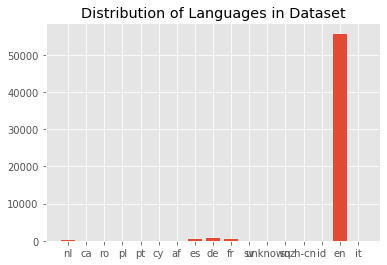

In [ ]:
# A Look at the language distribution
df_covid['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [ ]:
# Will be dropping any language that is not english
df_covid = df_covid[df_covid['language'] == 'en'] 
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55710 entries, 0 to 64445
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             55710 non-null  object
 1   doi                  55710 non-null  object
 2   abstract             55710 non-null  object
 3   body_text            55710 non-null  object
 4   authors              55710 non-null  object
 5   title                55710 non-null  object
 6   journal              55710 non-null  object
 7   abstract_summary     55710 non-null  object
 8   abstract_word_count  55710 non-null  int64 
 9   body_word_count      55710 non-null  int64 
 10  body_unique_words    55710 non-null  int64 
 11  language             55710 non-null  object
dtypes: int64(3), object(9)
memory usage: 5.5+ MB


In [ ]:
# Saved the cleaned dataset
df_covid.to_csv('df_covid.csv')

# Preparation of the data for the application of BERT Model

In [ ]:
import pandas as pd
df_covid = pd.read_csv('/content/drive/My Drive/data/df_covid.csv')

In [ ]:
df_covid = df_covid.dropna(how = 'any',axis=0)

In [ ]:
df_covid.isnull()

,Unnamed: 0,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language
0,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55702,False,False,False,False,False,False,False,False,False,False,False,False,False
55703,False,False,False,False,False,False,False,False,False,False,False,False,False
55707,False,False,False,False,False,False,False,False,False,False,False,False,False
55708,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
df_covid.to_csv('df_covid''.csv')

In [ ]:
from IPython.utils import io
with io.capture_output() as captured:
    !pip install scispacy
    !pip install '/content/drive/My Drive/data/archive/en_core_sci_md-0.2.4'

In [ ]:
import numpy as np 
import pandas as pd
import scispacy
import spacy
from spacy.lang.en import English
from gensim.models import Word2Vec
from tqdm import tqdm
import en_core_sci_md
import logging 

df = pd.read_csv('/content/df_covid.csv')

df.abstract = df.abstract.dropna()
df.abstract = df.abstract.astype(str)
abstract_doc = ' '.join(df.abstract)

nlp = English()
nlp.add_pipe(nlp.create_pipe('sentencizer'))
nlp.max_length = 90000000
doc = nlp(abstract_doc)
sentences = [sent.string.strip() for sent in doc.sents]

nlp_tkn = en_core_sci_md.load()
customize_stop_words = ['Abstract', 'article']
for w in customize_stop_words:
    nlp_tkn.vocab[w].is_stop = True

abstract_tokens = []
for sentence in tqdm(sentences):
    sent = nlp_tkn(sentence)
    token_list = [token.lemma_.lower() for token in sent if not token.is_punct | token.is_space | token.is_stop] 
    abstract_tokens.append(token_list)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
model = Word2Vec(abstract_tokens, 
                 min_count=5,   # Ignore words that appear less than this
                 size=100,      # Dimensionality of word embeddings
                 workers=4,     # Number of processors (parallelisation)
                 window=10,     # Context window for words during training) 
                 iter=10)     

model.save('word2vec.model')
model = Word2Vec.load("word2vec.model")
model.wv.save_word2vec_format('abstract_word2vec_embeddings')
model.most_similar(positive=['transmission'], topn = 10)

/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_sci_md' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
100%|██████████| 415575/415575 [56:24<00:00, 122.79it/s]
2020-12-31 17:56:30,425 : INFO : collecting all words and their counts
2020-12-31 17:56:30,425 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-31 17:56:30,455 : INFO : PROGRESS: at sentence #10000, processed 123870 words, keeping 17019 word types
2020-12-31 17:56:30,486 : INFO : PROGRESS: at sentence #20000, processed 251929 words, keeping 26958 word types
2020-12-31 17:56:30,516 : INFO : PROGRESS: at sentence #30000, processed 379332 words, keeping 34

[('spread', 0.7440241575241089),
 ('spillover', 0.6482548713684082),
 ('contact', 0.5907633900642395),
 ('transmit', 0.5866668224334717),
 ('spreading', 0.5531315803527832),
 ('dissemination', 0.540109395980835),
 ('dispersal', 0.5297764539718628),
 ('transmissibility', 0.5191208124160767),
 ('epidemic', 0.5162222385406494),
 ('outbreak', 0.5151717662811279)]

# Generate the train and test data

In [ ]:
# Importing all the libraries
import numpy as np 
import pandas as pd 
import re
import numpy as np 
import pandas as pd
#import scispacy
import spacy
from spacy.lang.en import English
from gensim.models import Word2Vec
from tqdm import tqdm
#import en_core_sci_md
import logging

In [ ]:
def count_freq(input_text, key_word):
    '''
    This function is to calculate the frequency of each key_word in an input text.
    '''
    count = sum(1 for _ in re.finditer(r'(?i)\b%s\b' % re.escape(key_word), input_text))
    return count

def frequency_generator(key_words_weight, df, context_col):
    '''
    This function consumes the count_freq function and applies on the dataframe column (context_col) which has input text.
    It creates new columns with frequency for each key word in the dataframe. 
    '''
    key_words = [i[0] for i in key_words_weight]
    df[context_col] = df[context_col].astype(str)
    for word in key_words:
        df['count_' + str(word)] = df[context_col].apply(lambda x: count_freq(x, word))
    return df

def generate_training_data(df, context_col_name, sum_col_name, label_col_name, lower_b, neg_pos_ratio):
    '''
    This function has the following steps:
        1.Drop null and duplicated data in the context column.
        2.Generate positive examples which have at least n(lower_b) frequency of key words in the context.
        3.Generate negative examples which have none of the key words in the context. Its size is neg_pos_ratio * the size of the postive examples.
        4.Combine the positive and negative examples as the traning set and rename the label column.
    '''
    df = df.dropna(subset = [context_col_name])
    df = df.drop_duplicates(subset = [context_col_name])
    df_positive = df[df[sum_col_name] >= lower_b]
    negative_set = df[df[sum_col_name] == 0]
    df_negative = negative_set.sample(n = df_positive.shape[0] * neg_pos_ratio, replace=True, random_state=1)
    df_training = df_positive.append(df_negative)[[context_col_name, label_col_name]]
    df_training = df_training.rename(columns = {label_col_name:'label'})
    return df_training

def generate_test_data(df, context_col_name, sum_col_name, label_col_name, lower_b, upper_b, positive_size, neg_pos_ratio):
    '''
    This funtion is to generate test set which is similar as generating the training data.
    The distinctive point is the upper bound of positive set is defined in the arguements. 
    '''
    df = df.dropna(subset = [context_col_name])
    df = df.drop_duplicates(subset = [context_col_name])
    test_positive = df[(df[sum_col_name] > lower_b) & (df[sum_col_name] < upper_b)].sample(n = positive_size, replace = True, random_state = 1)
    test_negative = df[df[sum_col_name] == 0]
    test_negative = test_negative.sample(n = test_positive.shape[0] * neg_pos_ratio, replace=True, random_state=1)
    df_test = test_positive.append(test_negative)[[context_col_name, sum_col_name, label_col_name]]
    df_test = df_test.rename(columns = {label_col_name:'label'})
    return df_test

In [ ]:
metadata_df = pd.read_csv('/content/drive/My Drive/data/metadata.csv', dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
metadata_df = metadata_df.dropna(axis=0, subset=['abstract'])

In [ ]:
metadata_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [ ]:
'''Key words extracted from word2vec. For key words: transmission, incubation, virus shedding and shedding virus 
existing in the first task and subtasks, the weights are 1 for each word. For the remaining ones extracted 
from word2vec, the weights are based on word2vec similarity scores.
'''
w2v_model = Word2Vec.load("/content/drive/My Drive/data/df_covid_training_test_data/word2vec.model")
w2v_model.wv.save_word2vec_format('/content/drive/My Drive/cord_df_training_test_data/abstract_word2vec_embeddings')
key_words_weight = w2v_model.most_similar(positive=['transmission'], topn = 10)
key_words_weight = [('transmission', 1), 
 ('incubation', 1),
 ('virus shedding', 1),
 ('shedding virus', 1),
 ('environmental stability', 1)] + key_words_weight

print(key_words_weight)
keywords_weight_dict = dict(key_words_weight)

2020-12-31 18:01:12,645 : INFO : loading Word2Vec object from /content/drive/My Drive/data/df_covid_training_test_data/word2vec.model
2020-12-31 18:01:14,828 : INFO : loading wv recursively from /content/drive/My Drive/data/df_covid_training_test_data/word2vec.model.wv.* with mmap=None
2020-12-31 18:01:14,829 : INFO : setting ignored attribute vectors_norm to None
2020-12-31 18:01:14,829 : INFO : loading vocabulary recursively from /content/drive/My Drive/data/df_covid_training_test_data/word2vec.model.vocabulary.* with mmap=None
2020-12-31 18:01:14,833 : INFO : loading trainables recursively from /content/drive/My Drive/data/df_covid_training_test_data/word2vec.model.trainables.* with mmap=None
2020-12-31 18:01:14,834 : INFO : setting ignored attribute cum_table to None
2020-12-31 18:01:14,836 : INFO : loaded /content/drive/My Drive/data/df_covid_training_test_data/word2vec.model
2020-12-31 18:01:14,903 : INFO : storing 38451x100 projection weights into /content/drive/My Drive/cord_df

[('transmission', 1), ('incubation', 1), ('virus shedding', 1), ('shedding virus', 1), ('environmental stability', 1), ('spread', 0.7580268979072571), ('spillover', 0.64621901512146), ('contact', 0.6034995317459106), ('transmit', 0.5859647393226624), ('dissemination', 0.5617706775665283), ('spreading', 0.5543307065963745), ('movement', 0.5496647357940674), ('importation', 0.54944908618927), ('exposure', 0.548215389251709), ('transmissibility', 0.5438992977142334)]


# Generate Training set on abstract

In [ ]:
neg_pos_ratio = 4 #4 means the ratio of negative examples to positive examples is 4:1
threshold = 3 #3 is the 97th percentile of the dot product of key words frequency and weights on the abstract context
meta_df = frequency_generator(key_words_weight, metadata_df, 'abstract')
col_list = ['count_' + i for i in list(keywords_weight_dict)]
meta_df['keywords_sum'] = meta_df[col_list].values.dot(pd.Series(keywords_weight_dict))
meta_df['keywords_exist'] = meta_df['keywords_sum'].apply(lambda x: 1 if x>= threshold else 0)
training_set = generate_training_data(meta_df, 'abstract', 'keywords_sum', 'keywords_exist', threshold, neg_pos_ratio)
training_set.to_csv('training_set_threshold_' + str(threshold) + '.csv')

In [ ]:
training_df = pd.read_csv('training_set_threshold_3.csv')

# New Section

In [ ]:
training_df.head()

,Unnamed: 0,abstract,label
0,17,BACKGROUND: Previous smallpox ring vaccination...,1
1,68,"BACKGROUND: EpiFlex is a flexible, easy to use...",1
2,96,"Despite intensive ongoing research, key aspect...",1
3,110,The human APOBEC3G protein is an innate anti-v...,1
4,127,Influenza A viruses have a wide host range for...,1


# Generate Test set on Body_Text

In [ ]:
threshold = 38 #38 is the 97th percentile of the dot product of key words frequency and weights on the body text context
full_data = pd.read_csv('/content/df_covid.csv') #This dataset is the output of this notebook: https://www.kaggle.com/danielwolffram/cord-19-create-dataframe
full_text_freq = frequency_generator(key_words_weight, full_data, 'body_text')
full_text_freq['keywords_sum'] = full_text_freq[col_list].values.dot(pd.Series(keywords_weight_dict))
full_text_freq['keywords_exist'] = full_text_freq['keywords_sum'].apply(lambda x: 1 if x >= threshold else (0 if x == 0 else None))

In [ ]:
#Take the first 3000 characters of body_text as test data
full_text_freq['body_text'] = full_text_freq['body_text'].apply(lambda x: re.sub(r'[^\w\s]','',x)[:3000])
full_text_freq = full_text_freq.rename(columns = {'keywords_exist': 'label'})
full_text_freq.to_csv('body_text_with_keywords_freq_38.csv')

In [ ]:
test_df = pd.read_csv('body_text_with_keywords_freq_38.csv')

In [ ]:
test_df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,count_transmission,count_incubation,count_virus shedding,count_shedding virus,count_environmental stability,count_spread,count_spillover,count_contact,count_transmit,count_dissemination,count_spreading,count_movement,count_importation,count_exposure,count_transmissibility,keywords_sum,label
0,0,0,0,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis FIP is a fatal c...,"Cornelissen, E.. Dewerchin, H. L.. Van Hamm...",Absence of surface expression of feline<br>in...,Veterinary Microbiology,Feline infectious peritonitis virus (FIPV)<br...,165,2071,756,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
1,1,2,2,00039b94e6cb7609ecbddee1755314bcfeb77faa,10.1111/j.1365-2249.2004.02415.x,Severe acute respiratory syndrome (SARS) is a ...,Severe acute respiratory syndrome SARS is a re...,"WONG, C K. LAM, C W K. WU, A K L. IP, W K....",Plasma inflammatory cytokines and chemokines<...,Clinical & Experimental Immunology,Severe acute respiratory syndrome (SARS) is a...,179,2822,1103,en,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1.603500,NaN
2,2,4,4,0004456994f6c1d5db7327990386d33c01cff32a,10.1186/1471-2334-10-8,Background: Influenza immunisation for healthc...,The German standing commission for immunisatio...,"Williams, Chris J. Schweiger, Brunhilde. <br...",Seasonal influenza risk in hospital<br>health...,BMC Infect Dis,Background: Influenza immunisation for<br>hea...,365,4414,1396,en,3,0,0,0,0,0,0,12,2,0,0,0,0,7,0,15.251432,NaN
3,3,7,7,00073cb65dd2596249230fab8b15a71c4a135895,10.1086/605034,A clinical picture of patients with acute resp...,Since then many clinical case reports have bee...,"Kawachi, Shoji. Luong, San Thi. Shigematsu,...",Risk Parameters of Fulminant Acute<br>Respira...,J Infect Dis,A clinical picture of patients with acute<br>...,255,1653,649,en,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.603500,NaN
4,4,9,9,0008c57de475138d903f2cca7003cf1e1ad93cf4,10.1140/epje/i2018-11644-5,We study the local effect of the antimicrobial...,The effect on the cell membrane of inclusions ...,"Azar, Elise. Constantin, Doru. Warschawski,...",The effect of gramicidin inclusions on the<br...,Eur Phys J E Soft Matter,We study the local effect of the antimicrobia...,102,4383,1315,en,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.603500,NaN


#Bert Classification *Model*

In [ ]:
! pip install transformers==3.5.1

     |████████████████████████████████| 1.3MB 13.0MB/s 
     |████████████████████████████████| 890kB 53.5MB/s 
     |████████████████████████████████| 1.1MB 49.5MB/s 
     |████████████████████████████████| 2.9MB 50.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=82dfa82ee78226a57961e05319195a92de0bd1125e9d3273d59b704fe213bd28
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import csv
import random
import time
import datetime
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
class train_bert:
    def __init__(self, training_df, context_col, label_col):
        self.df = training_df
        self.df[context_col] = self.df[context_col].astype('str')
        self.context = self.df[context_col].values
        self.label = self.df[label_col].values
    
    def tokenizer(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
        self.input_ids = []
        self.attention_masks = []
        for item in self.context:
            self.encoded_dict = self.tokenizer.encode_plus(
                    item,                      
                    add_special_tokens = True, 
                    max_length = 300,           
                    pad_to_max_length = True,
                    truncation = 'longest_first',
                    return_attention_mask = True,  
                    return_tensors = 'pt')
            self.input_ids.append(self.encoded_dict['input_ids'])
            self.attention_masks.append(self.encoded_dict['attention_mask'])
        self.input_ids = torch.cat(self.input_ids, dim=0)
        self.attention_masks = torch.cat(self.attention_masks, dim=0)
        self.label = torch.tensor(self.label)    
        return self
    
    def data_preparation(self, train_val_ratio): 
        self.dataset = TensorDataset(self.input_ids, self.attention_masks, self.label)
        self.train_size = int(train_val_ratio * len(self.dataset))
        self.val_size = len(self.dataset) - self.train_size
        self.train_dataset, self.val_dataset = random_split(self.dataset, [self.train_size, self.val_size])
        print('{:>5,} training samples'.format(self.train_size))
        print('{:>5,} validation samples'.format(self.val_size))
        return self
    
    def generate_data_loader(self, batch_size):
        self.batch_size = batch_size
        self.train_dataloader = DataLoader(
                    self.train_dataset,
                    sampler = RandomSampler(self.train_dataset),
                    batch_size = self.batch_size)
        self.validation_dataloader = DataLoader(
                    self.val_dataset,
                    sampler = SequentialSampler(self.val_dataset),
                    batch_size = self.batch_size)
        return self
    
    def model(self):
        self.model = BertForSequenceClassification.from_pretrained(
                    'bert-base-uncased', 
                    num_labels = 2,  
                    output_attentions = False, 
                    output_hidden_states = False)
        self.model.cuda()
        return self
    
    def optimizer(self):
        self.optimizer = AdamW(self.model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )
        return self
    
    def scheduler(self, epochs):
        self.epochs = epochs
        self.total_steps = len(self.train_dataloader) * self.epochs
        self.scheduler = get_linear_schedule_with_warmup(
                    self.optimizer, 
                    num_warmup_steps = 0,
                    num_training_steps = self.total_steps)
        return self
    
    def fine_tuning(self, seed_val):
        self.seed_val = seed_val
        random.seed(self.seed_val)
        np.random.seed(self.seed_val)
        torch.manual_seed(self.seed_val)
        torch.cuda.manual_seed_all(self.seed_val)
        self.training_stats = []
        self.total_t0 = time.time()
        for epoch_i in range(0, self.epochs):
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, self.epochs))
            print('Training...')
            self.t0 = time.time()
            self.total_train_loss = 0
            self.model.train()
            
            for step, batch in enumerate(self.train_dataloader):
                if step % 40 == 0 and not step == 0:
                    self.elapsed = format_time(time.time() - self.t0)
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(self.train_dataloader), self.elapsed))
                self.b_input_ids = batch[0].to(device)
                self.b_input_mask = batch[1].to(device)
                self.b_labels = batch[2].to(device)
                self.model.zero_grad()        

                self.loss, self.logits = self.model(self.b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=self.b_input_mask, 
                             labels=self.b_labels)
                self.total_train_loss += self.loss.item()
                self.loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                self.scheduler.step()
            self.avg_train_loss = self.total_train_loss / len(self.train_dataloader)        
            self.training_time = format_time(time.time() - self.t0)
            print("")
            print("  Average training loss: {0:.2f}".format(self.avg_train_loss))
            print("  Training epcoh took: {:}".format(self.training_time))

            print("")
            print("Running Validation...")

            self.t0 = time.time()
            self.model.eval()

            self.total_eval_accuracy = 0
            self.total_eval_loss = 0
            self.nb_eval_steps = 0

            for batch in self.validation_dataloader:
                self.b_input_ids = batch[0].to(device)
                self.b_input_mask = batch[1].to(device)
                self.b_labels = batch[2].to(device)
                with torch.no_grad():
                    (self.loss, self.logits) = self.model(self.b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=self.b_input_mask,
                                   labels=self.b_labels)
                self.total_eval_loss += self.loss.item()
                self.logits = self.logits.detach().cpu().numpy()
                self.label_ids = self.b_labels.to('cpu').numpy()
                self.total_eval_accuracy += flat_accuracy(self.logits, self.label_ids)
            self.avg_val_accuracy = self.total_eval_accuracy / len(self.validation_dataloader)
            print("  Accuracy: {0:.3f}".format(self.avg_val_accuracy))
            self.avg_val_loss = self.total_eval_loss / len(self.validation_dataloader)
            self.validation_time = format_time(time.time() - self.t0)
            print("  Validation Loss: {0:.3f}".format(self.avg_val_loss))
            print("  Validation took: {:}".format(self.validation_time))
            self.training_stats.append(
                {
            'epoch': epoch_i + 1,
            'Training Loss': self.avg_train_loss,
            'Valid. Loss': self.avg_val_loss,
            'Valid. Accur.': self.avg_val_accuracy,
            'Training Time': self.training_time,
            'Validation Time': self.validation_time
                }
            )
        
        print("")
        print("Training complete!")
        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()- self.total_t0)))
        return self
    
    def save_model(self, file_name):
        self.file_name = file_name
        torch.save(self.model, self.file_name)

In [ ]:
df = pd.read_csv('/content/training_set_threshold_3.csv', engine = 'python', sep= ',', header=0)
bert = train_bert(df, 'abstract', 'label' )
token = bert.tokenizer().data_preparation(0.9).generate_data_loader(16).model().optimizer().scheduler(2).fine_tuning(42)

2020-12-31 18:18:48,043 : INFO : Lock 139815325679456 acquired on /root/.cache/torch/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


2020-12-31 18:18:48,110 : INFO : Lock 139815325679456 released on /root/.cache/torch/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


2020-12-31 18:20:39,850 : INFO : Lock 139810179666552 acquired on /root/.cache/torch/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.637c6035640bacb831febcc2b7f7bee0a96f9b30c2d7e9ef84082d9f252f3170.lock


21,370 training samples
2,375 validation samples


2020-12-31 18:20:39,902 : INFO : Lock 139810179666552 released on /root/.cache/torch/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.637c6035640bacb831febcc2b7f7bee0a96f9b30c2d7e9ef84082d9f252f3170.lock
2020-12-31 18:20:39,938 : INFO : Lock 139818805097248 acquired on /root/.cache/torch/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock


2020-12-31 18:20:45,515 : INFO : Lock 139818805097248 released on /root/.cache/torch/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,336.    Elapsed: 0:00:34.
  Batch    80  of  1,336.    Elapsed: 0:01:09.
  Batch   120  of  1,336.    Elapsed: 0:01:46.
  Batch   160  of  1,336.    Elapsed: 0:02:25.
  Batch   200  of  1,336.    Elapsed: 0:03:03.
  Batch   240  of  1,336.    Elapsed: 0:03:41.
  Batch   280  of  1,336.    Elapsed: 0:04:20.
  Batch   320  of  1,336.    Elapsed: 0:04:58.
  Batch   360  of  1,336.    Elapsed: 0:05:36.
  Batch   400  of  1,336.    Elapsed: 0:06:15.
  Batch   440  of  1,336.    Elapsed: 0:06:53.
  Batch   480  of  1,336.    Elapsed: 0:07:31.
  Batch   520  of  1,336.    Elapsed: 0:08:10.
  Batch   560  of  1,336.    Elapsed: 0:08:48.
  Batch   600  of  1,336.    Elapsed: 0:09:27.
  Batch   640  of  1,336.    Elapsed: 0:10:05.
  Batch   680  of  1,336.    Elapsed: 0:10:43.
  Batch   720  of  1,336.    Elapsed: 0:11:22.
  Batch   760  of  1,336.    Elapsed: 0:12:00.
  Batch   800  of  1,336.    Elapsed: 0:12:39.
  Batch   840  of

In [ ]:
token.save_model('bert_model_3')

In [ ]:
model_train = torch.load('/content/bert_model_3')

In [ ]:
test_df = pd.read_csv('/content/body_text_with_keywords_freq_38.csv')

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38367 entries, 0 to 38366
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     38367 non-null  int64  
 1   Unnamed: 0.1                   38367 non-null  int64  
 2   Unnamed: 0.1.1                 38367 non-null  int64  
 3   paper_id                       38367 non-null  object 
 4   doi                            38367 non-null  object 
 5   abstract                       38367 non-null  object 
 6   body_text                      38367 non-null  object 
 7   authors                        38367 non-null  object 
 8   title                          38367 non-null  object 
 9   journal                        38367 non-null  object 
 10  abstract_summary               38367 non-null  object 
 11  abstract_word_count            38367 non-null  int64  
 12  body_word_count                38367 non-null 

In [ ]:
 test_df= test_df[['Unnamed: 0', 'body_text', 'label']]

In [ ]:
test_df.head()

,Unnamed: 0,body_text,label
0,0,Feline infectious peritonitis FIP is a fatal c...,0.0
1,1,Severe acute respiratory syndrome SARS is a re...,NaN
2,2,The German standing commission for immunisatio...,NaN
3,3,Since then many clinical case reports have bee...,NaN
4,4,The effect on the cell membrane of inclusions ...,NaN


In [ ]:
test_df = test_df.dropna(how = 'any',axis=0)

In [ ]:
test_df.isnull()

,Unnamed: 0,body_text,label
0,False,False,False
9,False,False,False
11,False,False,False
14,False,False,False
15,False,False,False
...,...,...,...
38347,False,False,False
38357,False,False,False
38361,False,False,False
38364,False,False,False


In [ ]:
test_df.head()

,Unnamed: 0,body_text,label
0,0,Feline infectious peritonitis FIP is a fatal c...,0.0
9,9,In contrast to the lengthy often redundant gen...,0.0
11,11,iNTRODUCTiON Human beings are constantly expos...,0.0
14,14,Heart arrhythmia is known as abnormal heart rh...,0.0
15,15,Feline infectious peritonitis virus FIPV famil...,0.0


In [ ]:
class prediction:
    
    def __init__(self, test_df, context_col, label_col, model_train):
        self.df = test_df
        self.context_col = context_col
        self.model_train = model_train
        self.df[context_col] = self.df[context_col].astype('str')
        self.context = self.df[context_col].values
        self.label = self.df[label_col].values
        print('Number of {}: {:,}\n'.format(context_col, df.shape[0]))
    
    def test_tokenizer(self):
        train_bert.tokenizer(self)
        return self
    
    def prediction(self, batch_size):
        self.batch_size = batch_size
        self.prediction_data = TensorDataset(self.input_ids, self.attention_masks, self.label)
        self.prediction_sampler = SequentialSampler(self.prediction_data)
        self.prediction_dataloader = DataLoader(self.prediction_data, sampler=self.prediction_sampler, batch_size=self.batch_size)
        print('Predicting labels for {:,} test {}...'.format(len(self.input_ids), self.context_col))
        self.model_train.eval()
        self.predictions , self.true_labels = [], []
        for batch in self.prediction_dataloader:
            batch = tuple(t.to(device) for t in batch)
            self.b_input_ids, self.b_input_mask, self.b_labels = batch
            with torch.no_grad():
                self.outputs = self.model_train(self.b_input_ids, token_type_ids=None, 
                      attention_mask=self.b_input_mask)
            self.logits = self.outputs[0]
            self.logits = self.logits.detach().cpu().numpy()
            self.label_ids = self.b_labels.to('cpu').numpy()
            self.predictions.append(self.logits)
            self.true_labels.append(self.label_ids)
        print('    DONE.')
        return self

In [ ]:
prediction = prediction(test_df, 'body_text', 'label', model_train).test_tokenizer().prediction(16)

Number of body_text: 23,745



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 10,160 test body_text...
    DONE.


In [ ]:
flat_predictions = np.concatenate(prediction.predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(prediction.true_labels, axis=0)

In [ ]:
# Confusion matrix for the BERT Model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(flat_true_labels, flat_predictions)
print(cm)

[[9487   10]
 [ 110  553]]


In [ ]:
# Calculating the presicion and recall for the BERT Model
tn, fp, fn, tp = confusion_matrix(flat_true_labels, flat_predictions).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print('The precision is {}'.format(precision))
print('The recall is {}'.format(recall))

The precision is 0.9822380106571936
The recall is 0.8340874811463047


In [ ]:
# Calculating the accuracy score for the BERT Model
from sklearn.metrics import accuracy_score 
print(accuracy_score(flat_true_labels,flat_predictions))

0.9881889763779528


In [ ]:
# Importing the required libraries for generating the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
roc_curve(flat_true_labels,flat_predictions)

(array([0.        , 0.00105296, 1.        ]),
 array([0.        , 0.83408748, 1.        ]),
 array([2, 1, 0]))

In [ ]:
fpr, tpr, thresholds = roc_curve(flat_true_labels,flat_predictions)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

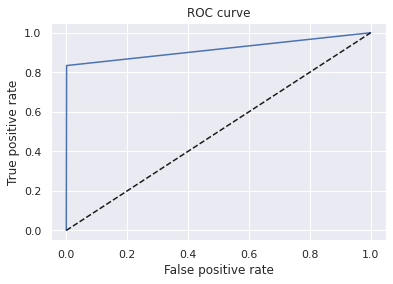

In [ ]:
# Generating the ROC Curve
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [ ]:
# ROC Score
AUROC = roc_auc_score(flat_true_labels,flat_predictions)
AUROC

0.9165172585261903

In [ ]:
# Calculating the f1_score
from sklearn.metrics import f1_score
f1 = f1_score(flat_true_labels,flat_predictions)
print('F1 score: %f' % f1)

F1 score: 0.902121


# Preparing the data for the application of CNN Model

In [ ]:
# Getting the training data
train_data = pd.read_csv('/content/training_set_threshold_3.csv')

In [ ]:
# Getting the test data
test_data = pd.read_csv('/content/body_text_with_keywords_freq_38.csv')

In [ ]:
 test_data= test_data[['Unnamed: 0', 'body_text', 'label']]

In [ ]:
test_data.isnull()

,Unnamed: 0,body_text,label
0,False,False,False
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True
...,...,...,...
38362,False,False,True
38363,False,False,True
38364,False,False,False
38365,False,False,False


In [ ]:
test_data = test_data.dropna(how = 'any',axis=0)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10160 entries, 0 to 38365
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10160 non-null  int64  
 1   body_text   10160 non-null  object 
 2   label       10160 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 317.5+ KB


In [ ]:
!pip install pandas_summary

In [ ]:
# Importing the libraries
import pandas as pd
import re
import numpy as np
from keras.preprocessing import sequence
from keras.regularizers import l2
from keras.models import Model
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, GlobalMaxPooling1D, Activation, Dropout, GaussianNoise
from keras.layers import Embedding, Input, BatchNormalization, SpatialDropout1D, Conv1D
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from IPython.display import display
import itertools
from nltk.corpus import words
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
train_data['l'] = train_data['abstract'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(train_data.l.mean()))
print("max length of sentence: " + str(train_data.l.max()))
print("std dev length of sentence: " + str(train_data.l.std()))

mean length of sentence: 207.04000842282585
max length of sentence: 18000
std dev length of sentence: 150.16008135771523


In [ ]:
# Load data


x_train = train_data["abstract"].fillna("_NaN_").values
x_test = test_data["body_text"].fillna("_NaN_").values
y_train = train_data["label"].values
y_test = test_data["label"].values

In [ ]:
# these sentences aren't that long so we may as well use the whole string
sequence_length = 200

In [ ]:
max_features = 20000 # this is the number of words we care about
maxlen = 200

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
#tokenizer.fit_on_texts(train_data["abstract"].values)

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train))
X_train = list_tokenized_train = tokenizer.texts_to_sequences(x_train)
X_test = list_tokenized_test = tokenizer.texts_to_sequences(x_test)

X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)



In [ ]:
y_train = np.asarray(train_data['label']).astype('float32').reshape((-1,1))
y_test = np.asarray(test_data['label']).astype('float32').reshape((-1,1))

In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
import re

import matplotlib.pyplot as plt
%matplotlib inline
from keras import regularizers

In [ ]:
embedding_dim = 200 # Kim uses 300 here
num_filters = 100

inputs = Input(shape=(sequence_length,), dtype='int32')

# use a random embedding for the text
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length)(inputs)

reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)

# Note the relu activation which Kim specifically mentions
# He also uses an l2 constraint of 3
# Also, note that the convolution window acts on the whole 200 dimensions - that's important
conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)

# perform max pooling on each of the convoluations
maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)

# concat and flatten
concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)

# do dropout and predict
dropout = Dropout(0.5)(flatten)
output = Dense(units=5, activation='sigmoid')(dropout)

In [ ]:
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 200)     4000000     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 200, 200, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 198, 1, 100)  60100       reshape[0][0]                    
______________________________________________________________________________________________

In [ ]:
batch_size = 50 # Kim uses 50 here, I have a slightly smaller sample size than num
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/10
428/428 [==============================] - 26s 38ms/step - loss: 1.3437 - accuracy: 0.7636 - val_loss: 0.4115 - val_accuracy: 1.0000
Epoch 2/10
428/428 [==============================] - 13s 30ms/step - loss: 0.7044 - accuracy: 0.7782 - val_loss: 0.4819 - val_accuracy: 1.0000
Epoch 3/10
428/428 [==============================] - 13s 30ms/step - loss: 0.6945 - accuracy: 0.7813 - val_loss: 0.4164 - val_accuracy: 0.9996
Epoch 4/10
428/428 [==============================] - 13s 30ms/step - loss: 0.6939 - accuracy: 0.8097 - val_loss: 0.4320 - val_accuracy: 0.9937
Epoch 5/10
428/428 [==============================] - 13s 30ms/step - loss: 0.6911 - accuracy: 0.8292 - val_loss: 0.4551 - val_accuracy: 0.9684
Epoch 6/10
428/428 [==============================] - 12s 29ms/step - loss: 0.6933 - accuracy: 0.8327 - val_loss: 0.3971 - val_accuracy: 0.9709
Epoch 7/10
428/428 [==============================] - 12s 28ms/step - loss: 0.6864 - accuracy: 0.8365 - val_loss: 0.4973 - val_accuracy:

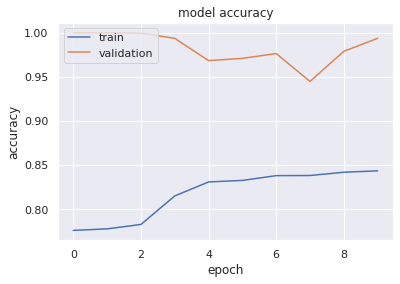

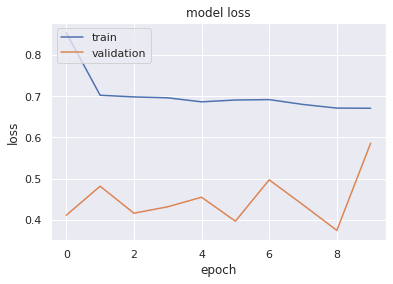

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_hat = model.predict(X_test)

In [ ]:
# Calculating the accuracy score for the CNN Model
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

0.9797244094488189

In [ ]:
# Generating the confusion matrix for the CNN Model
cm = confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))
print(cm)

[[9954  206]
 [   0    0]]


In [ ]:
# calculating the precision for the CNN Model
precision = np.diag(cm) / np.sum(cm, axis = 0)


In [ ]:
# The precision for CNN Model
np.mean(precision)

0.5

#Preparing the data for the application of Logistic Regression Model

In [ ]:
import numpy as np 
import pandas as pd 
import re
import numpy as np 
import pandas as pd
#import scispacy
import spacy
from spacy.lang.en import English
from gensim.models import Word2Vec
from tqdm import tqdm
#import en_core_sci_md
import logging

In [ ]:
# Loading the training data
train_data = pd.read_csv('/content/training_set_threshold_3.csv')

In [ ]:
# Loading the test data
test_data = pd.read_csv('/content/body_text_with_keywords_freq_38.csv')

In [ ]:
test_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,count_transmission,count_incubation,count_virus shedding,count_shedding virus,count_environmental stability,count_spread,count_spillover,count_contact,count_transmit,count_dissemination,count_spreading,count_movement,count_importation,count_exposure,count_transmissibility,keywords_sum,label
0,0,0,0,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis FIP is a fatal c...,"Cornelissen, E.. Dewerchin, H. L.. Van Hamm...",Absence of surface expression of feline<br>in...,Veterinary Microbiology,Feline infectious peritonitis virus (FIPV)<br...,165,2071,756,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
1,1,2,2,00039b94e6cb7609ecbddee1755314bcfeb77faa,10.1111/j.1365-2249.2004.02415.x,Severe acute respiratory syndrome (SARS) is a ...,Severe acute respiratory syndrome SARS is a re...,"WONG, C K. LAM, C W K. WU, A K L. IP, W K....",Plasma inflammatory cytokines and chemokines<...,Clinical & Experimental Immunology,Severe acute respiratory syndrome (SARS) is a...,179,2822,1103,en,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1.603500,NaN
2,2,4,4,0004456994f6c1d5db7327990386d33c01cff32a,10.1186/1471-2334-10-8,Background: Influenza immunisation for healthc...,The German standing commission for immunisatio...,"Williams, Chris J. Schweiger, Brunhilde. <br...",Seasonal influenza risk in hospital<br>health...,BMC Infect Dis,Background: Influenza immunisation for<br>hea...,365,4414,1396,en,3,0,0,0,0,0,0,12,2,0,0,0,0,7,0,15.251432,NaN
3,3,7,7,00073cb65dd2596249230fab8b15a71c4a135895,10.1086/605034,A clinical picture of patients with acute resp...,Since then many clinical case reports have bee...,"Kawachi, Shoji. Luong, San Thi. Shigematsu,...",Risk Parameters of Fulminant Acute<br>Respira...,J Infect Dis,A clinical picture of patients with acute<br>...,255,1653,649,en,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.603500,NaN
4,4,9,9,0008c57de475138d903f2cca7003cf1e1ad93cf4,10.1140/epje/i2018-11644-5,We study the local effect of the antimicrobial...,The effect on the cell membrane of inclusions ...,"Azar, Elise. Constantin, Doru. Warschawski,...",The effect of gramicidin inclusions on the<br...,Eur Phys J E Soft Matter,We study the local effect of the antimicrobia...,102,4383,1315,en,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.603500,NaN


In [ ]:
 test_data= test_data[['Unnamed: 0', 'body_text', 'label']]

In [ ]:
test_data = test_data.dropna(how = 'any',axis=0)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10160 entries, 0 to 38365
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10160 non-null  int64  
 1   body_text   10160 non-null  object 
 2   label       10160 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 317.5+ KB


In [ ]:
x_train = train_data['abstract']

In [ ]:
x_test = test_data['body_text']

In [ ]:
y_train = train_data['label'].values

In [ ]:
y_test = test_data['label'].values

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#vectorize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
ctv = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}',
                     ngram_range=(2, 3), stop_words='english')

In [ ]:

ctv.fit(list(x_train)+list(x_test))
xtrain_ctv = ctv.transform(x_train)
xtest_ctv = ctv.transform(x_test)

In [ ]:
#fit logistic regression on CountVectorizer
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1.0, max_iter=4000)
clf.fit(xtrain_ctv, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:

# predict probabilities for test set
yhat_probs = clf.predict(xtest_ctv)
# predict crisp classes for test set
yhat_classes = clf.predict(xtest_ctv)
# reduce to 1d array

In [ ]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, yhat_classes)
cnf_matrix

array([[9480,   17],
       [ 222,  441]])

In [ ]:
 # Calculating the precision score
 from sklearn.metrics import precision_score
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)

Precision: 0.962882


In [ ]:
# Calculating the recall score
from sklearn.metrics import recall_score
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)


Recall: 0.665158


In [ ]:
from sklearn.metrics import accuracy_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)

Accuracy: 0.976476


In [ ]:
# Calculating the f1_score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

F1 score: 0.786798


In [ ]:
# Importing the requitred libraries for the calculation of the ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score
roc_curve( y_test,yhat_classes)

(array([0.        , 0.00179004, 1.        ]),
 array([0.        , 0.66515837, 1.        ]),
 array([2, 1, 0]))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,yhat_classes)

Text(0.5, 1.0, 'ROC curve')

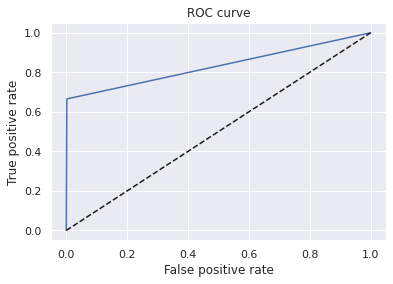

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [ ]:
# Calculating the ROC score
AUROC = roc_auc_score( y_test,yhat_classes)
AUROC

0.8316841660405262